# Time Series Experiment

In [43]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.0.1
CUDA available: False
CUDA version: None
CUDNN version: None


In [34]:
import scanpy as sc
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

adata = sc.read_h5ad("./data/sf4_rna2_06-18_combinedNeural_pca50_res0.6_raw_annotated.h5ad")

/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-pac

In [35]:
sc.pp.filter_cells(adata, min_genes=400) #filter out cells that express less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata, n_top_genes = 50)
adata_var = adata[:, adata.var.highly_variable]
adata_start = adata_var[(adata_var.obs['NNv1_age'] <= 10) & (adata_var.obs['NNv1_age'] >= 6)]
adata_end = adata_var[(adata_var.obs['NNv1_age'] <=18) & (adata_var.obs['NNv1_age'] >= 14)]

In [36]:
X = adata_end.to_df()
y = adata_start.to_df()
X_group = adata_end.obs['group']
y_group = adata_start.obs['group']
print('Unique cell types in early timepoints: {0}'.format([x for x in y_group.unique()]))
print('Unique cell types in late timepoints: {0}'.format([x for x in X_group.unique()]))

Unique cell types in early timepoints: ['Neural\nprogenitors', 'Immature\nsensory', 'Immature\nneurons', 'Ventral\nmidline', 'Sensory\nprogenitors', 'Unknown', 'Mature\nneurons']
Unique cell types in late timepoints: ['Immature\nneurons', 'Neural\nprogenitors', 'Mature\nneurons', 'Epidermis', 'Immature\nsensory', 'Ventral\nmidline', 'Sensory\nprogenitors', 'Unknown']


Notice highly unbalanced cell type representation; need for large rho values

In [37]:
X_group.value_counts()

group
Epidermis               3201
Neural\nprogenitors      658
Immature\nneurons        293
Unknown                  250
Mature\nneurons          200
Immature\nsensory         18
Ventral\nmidline          13
Sensory\nprogenitors       3
Name: count, dtype: int64

In [38]:
y_group.value_counts()

group
Neural\nprogenitors     6447
Sensory\nprogenitors     303
Ventral\nmidline         114
Immature\nneurons         93
Mature\nneurons           36
Unknown                    3
Immature\nsensory          1
Name: count, dtype: int64

Initial visualization

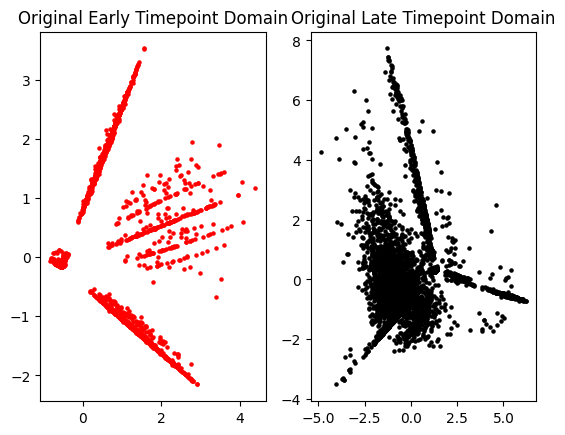

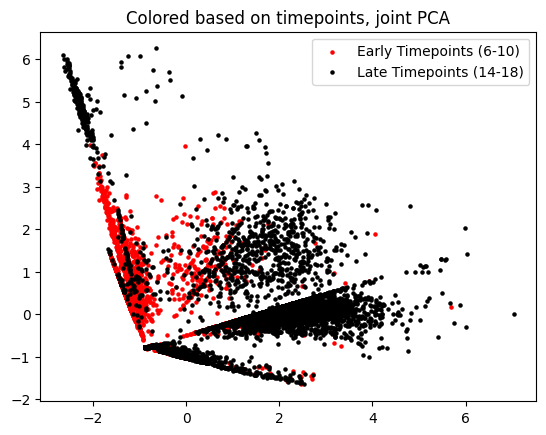

In [42]:
pca=PCA(n_components=2)

oX_pca=pca.fit_transform(X)
oy_pca=pca.fit_transform(y)

joint_pca=pca.fit_transform(np.concatenate((X, y), axis=0))
jX_pca=joint_pca[0:len(X.index),]
jy_pca=joint_pca[len(X.index):,]

fig, (ax1, ax2)= plt.subplots(1,2)
ax2.scatter(oX_pca[:,0], oX_pca[:,1], c="k", s=5)
ax2.set_title("Original Late Timepoint Domain")
ax1.scatter(oy_pca[:,0], oy_pca[:,1], c="r", s=5)
ax1.set_title("Original Early Timepoint Domain")
plt.show()

plt.scatter(jy_pca[:,0], jy_pca[:,1], c="r", s=5, label="Early Timepoints (6-10)")
plt.scatter(jX_pca[:,0], jX_pca[:,1], c="k", s=5, label="Late Timepoints (14-18)")
plt.legend()
plt.title("Colored based on timepoints, joint PCA")
plt.show()

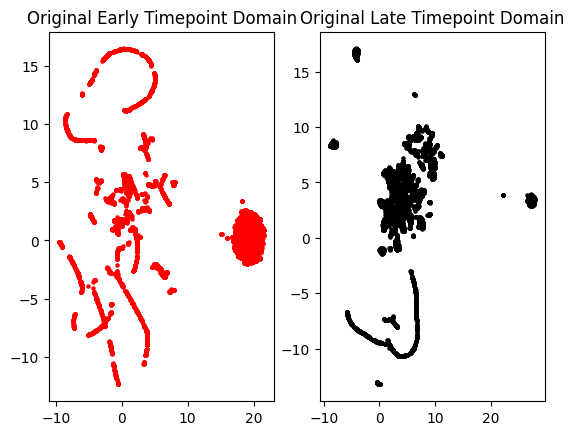

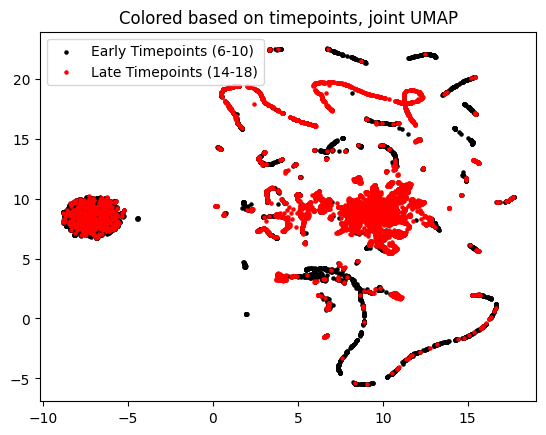

In [40]:
um = umap.UMAP(random_state=50)

oX_um=um.fit_transform(X)
oy_um=um.fit_transform(y)
joint_um = um.fit_transform(np.concatenate((X, y), axis=0))

jX_um = joint_um[0:len(X.index),]
jy_um = joint_um[len(X.index):,]

fig, (ax1, ax2)= plt.subplots(1,2)
ax2.scatter(oX_um[:,0], oX_um[:,1], c="k", s=5)
ax2.set_title("Original Late Timepoint Domain")
ax1.scatter(oy_um[:,0], oy_um[:,1], c="r", s=5)
ax1.set_title("Original Early Timepoint Domain")
plt.show()

plt.scatter(jy_um[:,0], jy_um[:,1], c="r", s=5, label="Early Timepoints (6-10)")
plt.scatter(jX_um[:,0], jX_um[:,1], c="k", s=5, label="Late Timepoints (14-18)")
plt.legend()
plt.title("Colored based on timepoints, joint UMAP")
plt.show()

GW try

In [45]:
import src.megawass as mw

megawass = mw.MegaWass()

Dx_knn, Dy_knn = torch.from_numpy(megawass.knn_dist(X, 50).astype('float32')).to(device), torch.from_numpy(megawass.knn_dist(y, 50).astype('float32')).to(device)

(pi_samp_gw, _), _ = megawass.solver_fugw_simple(Dx_knn, Dy_knn, eps=1e-2, rho=(1e-2, 1e-2), verbose=True)

/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


Cost at iteration 1: 0.01444044429808855
Cost at iteration 6: 0.01446492038667202


In [51]:
aligned_y_gw = megawass.get_barycentre(torch.from_numpy(y.to_numpy().astype('float32')).to(device), pi_samp_gw)
aligned_y_gw.numpy().shape

(4636, 50)

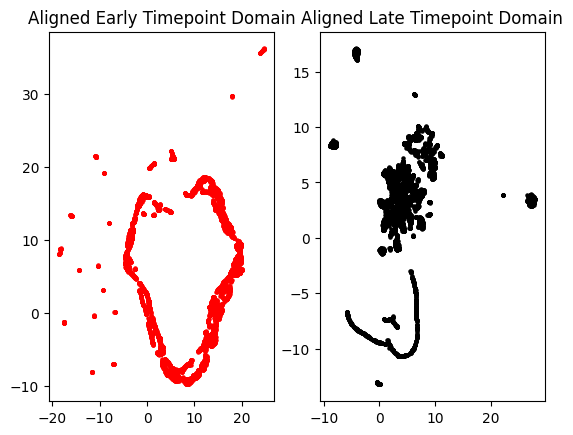

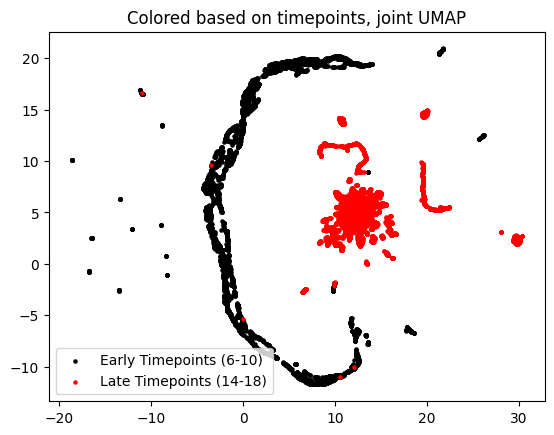

In [53]:
um = umap.UMAP(random_state=50)

oX_um=um.fit_transform(X)
oy_um=um.fit_transform(aligned_y_gw)
joint_um = um.fit_transform(np.concatenate((X, aligned_y_gw), axis=0))

jX_um = joint_um[0:len(X.index),]
jy_um = joint_um[len(X.index):,]

fig, (ax1, ax2)= plt.subplots(1,2)
ax2.scatter(oX_um[:,0], oX_um[:,1], c="k", s=5)
ax2.set_title("Aligned Late Timepoint Domain")
ax1.scatter(oy_um[:,0], oy_um[:,1], c="r", s=5)
ax1.set_title("Aligned Early Timepoint Domain")
plt.show()

plt.scatter(jy_um[:,0], jy_um[:,1], c="r", s=5, label="Early Timepoints (6-10)")
plt.scatter(jX_um[:,0], jX_um[:,1], c="k", s=5, label="Late Timepoints (14-18)")
plt.legend()
plt.title("Colored based on timepoints, joint UMAP")
plt.show()

In [79]:
(pi_samp_coot, pi_feat_coot), duals = megawass.solver_fucoot(torch.from_numpy(X.to_numpy().astype('float32')).to(device), torch.from_numpy(y.to_numpy().astype('float32')).to(device), eps=1e-3, rho=(1,1), verbose=True)

Cost at iteration 1: 0.2080649435520172
Cost at iteration 6: 0.14405684173107147
Cost at iteration 11: 0.13395678997039795
Cost at iteration 16: 0.13337735831737518
Cost at iteration 21: 0.13244153559207916
Cost at iteration 26: 0.13231056928634644
Cost at iteration 31: 0.13229288160800934
Cost at iteration 36: 0.13228832185268402
Cost at iteration 41: 0.13228994607925415
Cost at iteration 46: 0.13228657841682434
Cost at iteration 51: 0.13228826224803925


In [135]:
aligned_y_coot = megawass.get_barycentre(torch.from_numpy(X.to_numpy().astype('float32')).to(device), torch.from_numpy(pi_samp_coot.numpy().transpose()).to(device))
aligned_y_coot.numpy().shape
np.count_nonzero(np.isnan(aligned_y_coot))

0

In [131]:
y.shape

(6997, 50)

In [138]:
aligned_y_coot.shape

torch.Size([6997, 50])

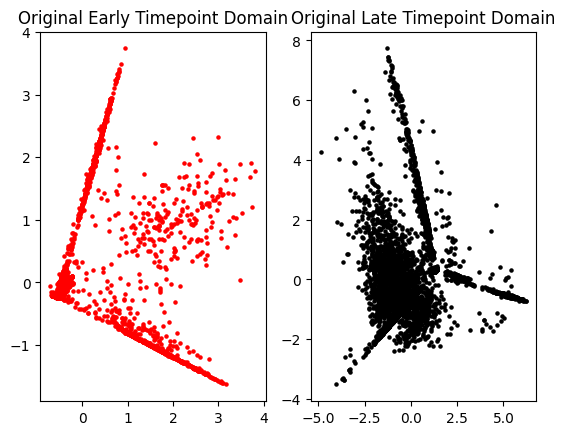

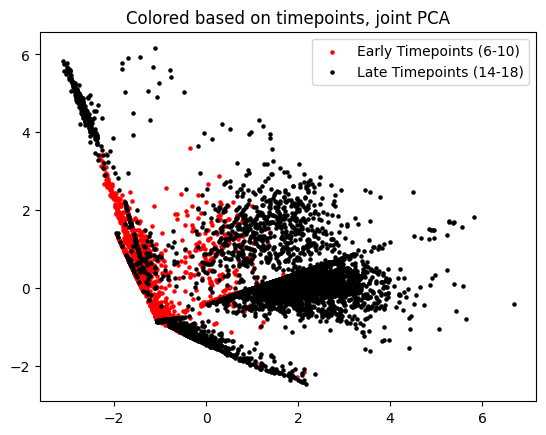

In [83]:
pca=PCA(n_components=2)

oX_pca=pca.fit_transform(X)
oy_pca=pca.fit_transform(aligned_y_coot)

joint_pca=pca.fit_transform(np.concatenate((X, aligned_y_coot), axis=0))
jX_pca=joint_pca[0:len(X.index),]
jy_pca=joint_pca[len(X.index):,]

fig, (ax1, ax2)= plt.subplots(1,2)
ax2.scatter(oX_pca[:,0], oX_pca[:,1], c="k", s=5)
ax2.set_title("Original Late Timepoint Domain")
ax1.scatter(oy_pca[:,0], oy_pca[:,1], c="r", s=5)
ax1.set_title("Original Early Timepoint Domain")
plt.show()

plt.scatter(jy_pca[:,0], jy_pca[:,1], c="r", s=5, label="Early Timepoints (6-10)")
plt.scatter(jX_pca[:,0], jX_pca[:,1], c="k", s=5, label="Late Timepoints (14-18)")
plt.legend()
plt.title("Colored based on timepoints, joint PCA")
plt.show()

In [139]:
um = umap.UMAP(random_state=50)

oX_um=um.fit_transform(X)
oy_um=um.fit_transform(pi_samp_coot)
joint_um = um.fit_transform(np.concatenate((X, aligned_y_coot), axis=0))

jX_um = joint_um[0:len(X.index),]
jy_um = joint_um[len(X.index):,]

In [129]:
aligned_y_coot.shape

torch.Size([4636, 50])

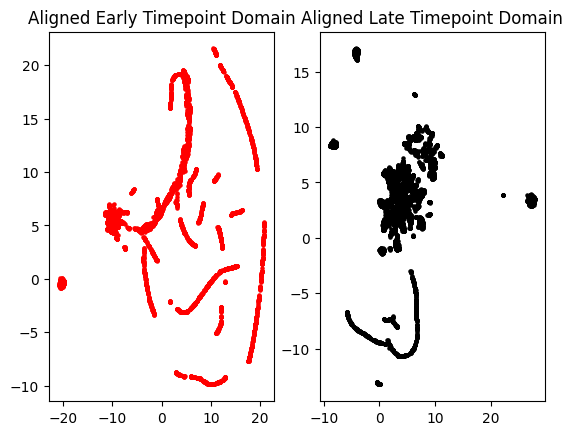

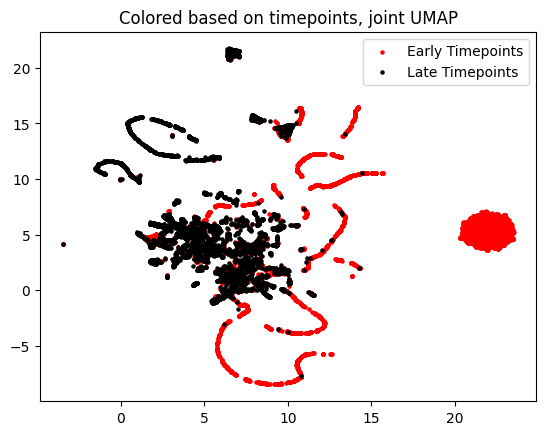

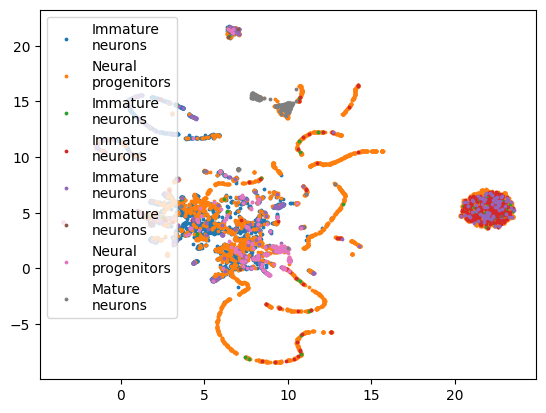

In [158]:
fig, (ax1, ax2)= plt.subplots(1,2)
ax2.scatter(oX_um[:,0], oX_um[:,1], c="k", s=5)
ax2.set_title("Aligned Late Timepoint Domain")
ax1.scatter(oy_um[:,0], oy_um[:,1], c="r", s=5)
ax1.set_title("Aligned Early Timepoint Domain")
plt.show()

plt.scatter(jy_um[:,0], jy_um[:,1], c="r", s=5, label="Early Timepoints")
plt.scatter(jX_um[:,0], jX_um[:,1], c="k", s=5, label="Late Timepoints")
plt.legend()
plt.title("Colored based on timepoints, joint UMAP")
plt.show()

for group in set([x for x in X_group.values] + [x for x in y_group.values]):
    cells_x = X_group.loc[X_group == group].index
    cells_y = y_group.loc[y_group == group].index
    joint_um_group = pd.DataFrame(joint_um, index=[x for x in X.index] + [x for x in y.index]).loc[[x for x in cells_x] + [x for x in cells_y]]
    plt.scatter(joint_um_group.iloc[:, 0], joint_um_group.iloc[:, 1], s=3)
    plt.legend(X_group)

Basic scoring scheme

In [116]:
import pandas as pd
def score(pi_samp, matching_set):
    labelled_ps = pd.DataFrame(data=pi_samp, index=X.index, columns=y.index)
    correct = 0
    incorrect = 0
    for x in labelled_ps.columns:
        col = labelled_ps[x].argmax()
        if y_group[x] in matching_set:
            if X_group[col] in matching_set:
                correct += 1
            else:
                incorrect += 1
    return (correct) / (correct + incorrect)

In [117]:
matching_set = set()
matching_set.add('Neural\nprogenitors')
matching_set.add('Immature\nneurons')
matching_set.add('Mature\nneurons')
matching_set_sensory = set()
matching_set_sensory.add('Neural\nprogenitors')
matching_set_sensory.add('Immature\nneurons')
matching_set_sensory.add('Mature\nneurons')
score(pi_samp_coot, matching_set)

0.6201338199513382

In [119]:
X_group.value_counts().loc[[x for x in matching_set],].sum() / y_group.value_counts().sum()

0.16449907103044162